In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from mlreading_hub.pml.em_hmm import *

### Hidden Markov Models (HMMs)
$$\begin{align*}P(O) &= \sum_Q P(O,Q)=\sum_Q P(O|Q)P(Q) \\ &= \sum_{j=1}^N \prod^T_{i=1}P(o_i|q_i)P(q_i|q_{i-1})= \sum_{j=1}^N \prod^T_{i=1}a_{ij}b(o_i)
\end{align*}$$
It is useful for 3 fundamental problems, 
1. Likelihood 
<p> Given an HMM $\lambda = (A,B)$ and an observation sequence $O$, determine the likelihood $P(O|\lambda)$. </p>
2. Decoding
<p> Given an observation sequence $O$ and and HMM $\lambda=(A,B)$, discover the best hidden state sequence Q. </p>
3. Learning
<p> Given an observation sequence $O$ and the set of states in the HMM, learn the HMM parameters $A$ and $B$. </p>

In [2]:
hmm = HMM()
hmm.setDistinctHiddensAndObservations([0,1,2,3],["H","C"])
hmm.setInitial({"H":0.7,"C":0.3})
hmm.setSpecificTransit("H",{"H":0.7,"C":0.3})
hmm.setSpecificTransit("C",{"H":0.8,"C":0.2})
hmm.setSpecificEmit("H",{0:0.2,1:0.7,2:0.05,3:0.05})
hmm.setSpecificEmit("C",{0:0.9,1:0.05,2:0.05})

#### 1. Likelihood: Forward Algorithm
a. Initialization
$$\alpha_1(j) = \pi_jb_j(o_1) \qquad 1\leq j\leq N$$
b. Recursion
$$\begin{align*}\alpha_t(j) &= P(\{o_i\}_{i=1}^t, q_t=j|\lambda) \\ 
&= \sum^N_{i=1}\alpha_{t-1}(i)a_{ij}b_j(o_t) \qquad 1\leq j\leq N\quad ,\quad 1<t\leq T \end{align*}$$
c. Termination
$$
P(O|\lambda) = \sum^N_{i=1}\alpha_T(i)
$$
<details>
<summary><h4>Click to view proof for Forward probability!</h4></summary>
$$\begin{align*}
\alpha_t(j) &= P(\{o_k\}^t_1,q_t=j|\lambda) = \sum^N_{i=1} P(\{o_k\}^{t-1}_1,o_t,q_t=j,q_{t-1}=i|\lambda)\\
&= \sum^N_{i=1}P(o_t|\{o_k\}^{t-1}_1,q_t=j,q_{t-1}=i,\lambda)P(q_t=j|\{o_k\}^{t-1}_1,q_{t-1}=i,\lambda) \\ &\qquad \times P(\{o_k\}^{t-1}_1,q_{t-1}=i|\lambda) \\
&= \sum^N_{i=1}P(\{o_k\}^{t-1}_1,q_{t-1}=i|\lambda)P(q_t=j|q_{t-1}=i,\lambda)P(o_t|q_t=j,\lambda) \\
&= \sum^N_{i=1}\alpha_{t-1}(i)a_{ij}b_j(o_t)
\end{align*}
$$
</details>

In [3]:
hmm.computeLikelihood = lambda x:likelihood(hmm,x)

In [4]:
print(hmm.computeLikelihood([1]))
print(hmm.computeLikelihood([0]))
print(hmm.computeLikelihood([2]))
print(hmm.computeLikelihood([3]))
print(hmm.computeLikelihood([1,1]))
print(hmm.computeLikelihood([1,0]))
print(hmm.computeLikelihood([0,1]))
print(hmm.computeLikelihood([0,0]))

(0.5049999999999999, array([[0.49 ],
       [0.015]]))
(0.41000000000000003, array([[0.14],
       [0.27]]))
(0.049999999999999996, array([[0.035],
       [0.015]]))
(0.034999999999999996, array([[0.035],
       [0.   ]]))
(0.25599999999999995, array([[0.49  , 0.2485],
       [0.015 , 0.0075]]))
(0.20599999999999996, array([[0.49 , 0.071],
       [0.015, 0.135]]))
(0.2246, array([[0.14  , 0.2198],
       [0.27  , 0.0048]]))
(0.1492, array([[0.14  , 0.0628],
       [0.27  , 0.0864]]))


#### 2. Decoding: Viterbi Algorithm
a. Initialization
$$\begin{align*}
v_1(j) &= \pi_jb_j(o_1) &\qquad 1\leq j\leq N \\
bt_1(j) &= 0 &\qquad 1\leq j\leq N
\end{align*}
$$
b. Recursion
$$\begin{align*}
v_t(j) &=\max_{\{q_k\}_1^{t-1}} P(\{q_k\}_1^{t-1},\{o_k\}_1^t,q_t=j | \lambda) \\&= \max^N_{i=1}v_{t-1}(i)a_{ij}b_j(o_t) &\qquad 1\leq j\leq N\quad ,\quad 1<t\leq T\\
bt_t(j) &= \arg\max^N_{i=1}v_{t-1}(i)a_{ij}b_j(o_t) &\qquad 1\leq j\leq N\quad ,\quad 1<t\leq T\\
\end{align*}
$$
c. Termination
$$\begin{align*}
P* &= \max^N_{i=1}v_T(i) \\
q_T* &= \arg\max^N_{i=1}v_T(i)
\end{align*}
$$

In [5]:
hmm.decode = lambda x:decode(hmm,x)

In [6]:
for o in hmm.o2id.keys():
    print(hmm.decode([o]))

(0.27, ['C'])
(0.48999999999999994, ['H'])
(0.034999999999999996, ['H'])
(0.034999999999999996, ['H'])


In [7]:
hmm.decode([0,0,0,0])

(0.0020995200000000006, ['C', 'C', 'C', 'C'])

#### 3. Learning: HMM Training with Forward-Backward Algorithm
> Backward Probability

a. Initialization
$$\beta_T(i) = 1 \qquad 1\leq i\leq N$$
b. Recursion
$$\begin{align*}
\beta_t(i) &= P(\{o_k\}_{t+1}^T|q_t=i,\lambda) \\
&=\sum^N_{j=1}a_{ij}b_j(o_{t+1})\beta_{t+1}(j) \qquad 1\leq i\leq N\quad,\quad 1\leq t<T
\end{align*}
$$
c. Termination
$$P(O|\lambda)=\sum^N_{j=1}\pi_j b_j(o_1)\beta_1(j)$$
<details >
<summary><h4>Click to view proof for Backward probability!</h4></summary>
$$\begin{align*}
\beta_t(i) &= P(\{o_k\}_{t+1}^T|q_t=i,\lambda) = \sum^N_{j=1}P(q_{t+1}=j,o_{t+1},\{o_k\}^T_{t+2}|q_t=i,\lambda) \\
&= \sum^N_{j=1}\frac{P(q_{t+1}=j,o_{t+1},\{o_k\}^T_{t+2},q_t=i|\lambda)}{P(q_t=i|\lambda)} \\
&= \sum^N_{j=1}\frac{P(o_{t+1}|q_{t+1}=j,\{o_k\}^T_{t+2},q_t=i,\lambda)\times\\P(\{o_k\}^T_{t+2}|q_{t+1}=j,q_t=i,\lambda)\times\\P(q_{t+1}=j|q_t=i,\lambda)P(q_t=i|\lambda)}{P(q_t=i|\lambda)} \\
&= \sum^N_{j=1}P(q_{t+1}=j|q_t=i,\lambda)P(o_{t+1}|q_{t+1}=j,\lambda)P(\{o_k\}^T_{t+2}|q_{t+1}=j,\lambda) \\
&= \sum^N_{j=1}a_{ij}b_j(o_{t+1})\beta_{t+1}(j)
\end{align*}$$
</details>



In [8]:
hmm.likelihood_backwards = lambda x:likelihood_backwards(hmm,x)               

In [9]:
print(hmm.computeLikelihood([1])[0],
      hmm.likelihood_backwards([1])[0])
print(hmm.computeLikelihood([0])[0],
      hmm.likelihood_backwards([0])[0])
print(hmm.computeLikelihood([2])[0],
      hmm.likelihood_backwards([2])[0])
print(hmm.computeLikelihood([3])[0],
      hmm.likelihood_backwards([3])[0])
print(hmm.computeLikelihood([1,1])[0],
      hmm.likelihood_backwards([1,1])[0])
print(hmm.computeLikelihood([1,0])[0],
      hmm.likelihood_backwards([1,0])[0])
print(hmm.computeLikelihood([0,1])[0],
      hmm.likelihood_backwards([0,1])[0])
print(hmm.computeLikelihood([0,0])[0],
      hmm.likelihood_backwards([0,0])[0])

0.5049999999999999 0.5049999999999999
0.41000000000000003 0.41000000000000003
0.049999999999999996 0.049999999999999996
0.034999999999999996 0.034999999999999996
0.25599999999999995 0.2559999999999999
0.20599999999999996 0.206
0.2246 0.22459999999999997
0.1492 0.14920000000000003


#### Sampling from HMM

In [10]:
hmm.samples = lambda x:samples(hmm,x)

In [11]:
N = 10
for i in range(N):
    Qs,Os = hmm.samples(6)
    l,alpha = hmm.computeLikelihood(Os)
    lB,beta = hmm.likelihood_backwards(Os)
    lQ,dQs = hmm.decode(Os)
    print(Qs,dQs,lQ,Os,l,lB)

['C', 'C', 'H', 'H', 'C', 'H'] ['C', 'C', 'H', 'H', 'C', 'H'] 0.002016379008 [0, 0, 1, 1, 0, 1] 0.009159656239999998 0.009159656239999998
['H', 'H', 'H', 'C', 'H', 'H'] ['H', 'H', 'H', 'C', 'H', 'H'] 0.008716379111999996 [1, 1, 1, 0, 1, 1] 0.014679843499999994 0.014679843499999989
['H', 'H', 'H', 'H', 'C', 'C'] ['H', 'H', 'C', 'H', 'C', 'C'] 0.0017643316319999993 [1, 1, 0, 1, 0, 0] 0.008505114799999998 0.008505114800000003
['H', 'H', 'H', 'C', 'H', 'H'] ['H', 'C', 'H', 'C', 'H', 'H'] 0.005489031743999998 [1, 0, 1, 0, 1, 1] 0.012779535999999992 0.012779535999999994
['H', 'C', 'H', 'H', 'H', 'H'] ['H', 'C', 'H', 'H', 'H', 'C'] 0.004802902775999998 [1, 0, 1, 1, 1, 0] 0.011812800999999994 0.011812800999999994
['C', 'H', 'H', 'C', 'H', 'C'] ['C', 'H', 'H', 'C', 'H', 'C'] 0.00021604060799999998 [0, 3, 1, 0, 1, 0] 0.0007234716999999999 0.0007234716999999999
['H', 'H', 'H', 'C', 'C', 'H'] ['C', 'H', 'H', 'C', 'C', 'H'] 0.002016379008 [0, 1, 1, 0, 0, 1] 0.00916802624 0.009168026239999997
['C', 

> Transition Probability Matrix $A$

$$\begin{align*}
    \hat{a}_{ij}&=\frac{\sum^{T-1}_{t=1}\xi_t(i,j)}{\sum^{T-1}_{t=1}\sum^N_{k=1}\xi_t(i,k)}\\
    \xi_t(i,j) &= \frac{\alpha_t(i)a_{ij}b_j(o_{t+1})\beta_{t+1}(j)}{\sum^N_{j=1}\alpha_t(j)\beta_t(j)}
\end{align*}$$
<details >
<summary><h4>Click to view proof for transition probability!</h4></summary>

</details>

> Emission Probabilities $B$

$$\begin{align*}
\hat{b}_j(v_k) &= \frac{\sum^T_{t=1 s.t.O_t=v_k}\gamma_t(j)}{\sum^T_{t=1}\gamma_t(j)} \\
\gamma_t(j) &= \frac{\alpha_t(j)\beta_t(j)}{\sum^N_{j=1}\alpha_t(j)\beta_t(j)}
\end{align*}$$
<details >
<summary><h4>Click to view proof for emission probability!</h4></summary>

</details>

In [12]:
hmm = add_patch(hmm)
N,T = 1000,6
Osamples = []
for _ in range(N):
    Qs,Os = hmm.samples(T)
    Osamples.append(Os)

In [13]:
print(Osamples[0:3])

[[0, 3, 1, 1, 0, 1], [1, 2, 1, 0, 1, 1], [1, 0, 1, 1, 1, 1]]


In [14]:
model = HMM()
model.setDistinctHiddensAndObservations([0,1,2,3],["H","C"])
model = add_patch(model)

In [15]:
print(model.A)
print(model.B)
print(model.pi)

defaultdict(<class 'dict'>, {0: {0: 0.7463814841629683, 1: 0.25361851583703166}, 1: {0: 0.4103958350006115, 1: 0.5896041649993885}})
defaultdict(<class 'dict'>, {0: {0: 0.3035199076961971, 1: 0.1098358950354559, 2: 0.2548711382714411, 3: 0.33177305899690596}, 1: {0: 0.12978360282522952, 1: 0.28403299458709375, 2: 0.4248038367457662, 3: 0.1613795658419105}})
{0: 0.7735268757426305, 1: 0.22647312425736962}


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


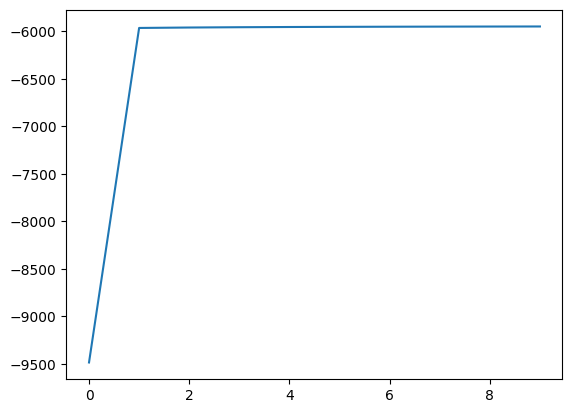

In [16]:
iters = 10
ls = model.learn(Osamples,iters)
plt.plot(range(iters),ls)
plt.show()

In [17]:
print(model.A)
print(model.B)
print(model.pi)

defaultdict(<class 'dict'>, {0: {0: 0.6843341709169032, 1: 0.31566582908309465}, 1: {0: 0.4181817070297851, 1: 0.5818182929702151}})
defaultdict(<class 'dict'>, {0: {0: 0.4879877742405634, 1: 0.4118542791739321, 2: 0.04914470285181439, 3: 0.05101324373368892}, 1: {0: 0.25306970072789886, 1: 0.665467657454194, 2: 0.06273651590822718, 3: 0.01872612590968179}})
{0: 0.6221873586495507, 1: 0.3778126413504499}


In [18]:
print(hmm.A)
print(hmm.B)
print(hmm.pi)

defaultdict(<class 'dict'>, {0: {0: 0.7, 1: 0.3}, 1: {0: 0.8, 1: 0.2}})
defaultdict(<class 'dict'>, {0: {0: 0.2, 1: 0.7, 2: 0.05, 3: 0.05}, 1: {0: 0.9, 1: 0.05, 2: 0.05, 3: 0}})
{0: 0.7, 1: 0.3}


### References
- https://web.stanford.edu/~jurafsky/slp3/A.pdf
- https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm
- http://personal.ee.surrey.ac.uk/Personal/P.Jackson/tutorial/hmm_tut4.pdf